## Options Parser
- Goal is see % change as a function of length of time, start and end time
- Additionally, look for slight (positive) bias of market

so
1. import data
    a. decide how long to take
2. sort it somehow
3. take inputs for length of time, start and end time, ITMness (ex: calc % change for both call and put, abt 3 dollar ITM, from 1pm to two days later close)
4. plot these % changes as histogram

In [6]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("../../data/aapl_30x_202307.txt", delimiter=", ")
# df = pd.read_csv("../../aapl_30x_2023_full_year.csv", engine='python')
df = df.drop(df.columns[[0, 6, 8,9,10,11,12, 13,14, 16,17,18, 20,21,22, 24,25,26,27,28, 29]], axis=1) # dont forget to acct for 0 ind
df["[QUOTE_DATE]"] = pd.to_datetime(df["[QUOTE_DATE]"])
df["[EXPIRE_DATE]"] = pd.to_datetime(df["[EXPIRE_DATE]"])

'''
[QUOTE_UNIXTIME], [QUOTE_READTIME], [QUOTE_DATE], [QUOTE_TIME_HOURS], [UNDERLYING_LAST], [EXPIRE_DATE], [EXPIRE_UNIX], [DTE], [C_DELTA], [C_GAMMA], [C_VEGA], [C_THETA], [C_RHO], [C_IV], [C_VOLUME], [C_LAST], [C_SIZE], [C_BID], [C_ASK], [STRIKE], [P_BID], [P_ASK], [P_SIZE], [P_LAST], [P_DELTA], [P_GAMMA], [P_VEGA], [P_THETA], [P_RHO], [P_IV], [P_VOLUME], [STRIKE_DISTANCE], [STRIKE_DISTANCE_PCT]
1672756210, 2023-01-03 09:30, 2023-01-03, 9.500000, 130.420000, 2023-01-06, 1673038800, 3.270000, 1.000000, 0.000000, 0.000000, -0.006560, 0.005160, , 0.000000, 79.350000, 1 x 11, 78.500000, 81.900000, 50.000000, 0.010000, 5.000000, 49 x 14, 0.010000, -0.046650, 0.000980, 0.013680, -1.105610, -0.000560, 6.989930, 0.000000, 80.400000, 0.617000
https://www.optionsdx.com/option-chain-field-definitions/
'''
# df[df["[STRIKE_DISTANCE]"] < 10] #  you can filter by this if you like
# df[df["[DTE]"]<10]

# df['[QUOTE_DATE]'][4]
# type(df["[STRIKE]"][5])
df.size

C:\Users\sxyan\AppData\Local\Temp\ipykernel_1128\1024667864.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("../../data/aapl_30x_202307.txt", delimiter=", ")


3138576

In [2]:
df.shape

(261548, 11)

#### Choose params

In [10]:
'''- Goal is see % change as a function of length of time, start and end time
- Additionally, look for slight (positive) bias of market

so
1. import data
    a. decide how long to take
2. sort it somehow
3. take inputs for length of time, start and end time, ITMness (ex: calc % change for both call and put, abt 3 dollar ITM, from 1pm to two days later close)
4. plot these % changes as histogram
'''

# start and end of collected data
startDate = '2023-07-01'
endDate = '2023-07-19' #'2023-12-26'

# or you could use datetime
startTime = 9.5 # quote time hours
daysForward = 1 # use quote date
endTime = 15.5 # quote time horus
ITMness = -1
DTE = 1 # idk if you can fuck w this too much. they only expire on friday sometimes


### NEXT STEPS: make call data array. [start price; end pricle ; % change] * n rows
do i want put data to be ITM the other way? so i'd have to double the searching?
now how do I deal w weekends? do I make a list of unique days that are available in the thing?

In [11]:
startDateCurrent = pd.to_datetime(startDate)
endDateCurrent = pd.to_datetime(endDate)

callQuotes = []
putQuotes = []
outputDf = pd.DataFrame(columns=["Start_Time", "End_Time",
                                 "Call_Returns", "Put_Returns", "Average_Returns",
                                "Underlying_Start", "Underlying_End", 
                                "Call_Start", "Call_End", 
                                "Put_Start", "Put_End", 
                                "Call_Strike", "Put_Strike", "DTE_Start","DTE_end",
                                "Call_ITM", "Put_ITM","dUnderlying", "dCall", "dPut"])
while startDateCurrent + dt.timedelta(days=daysForward) < endDateCurrent:
    # if startDateCurrent in pd.date_range('2023-02-05', '2023-02-08'):
    #     startDateCurrent += dt.timedelta(days=5)
    #     continue

    # make sure start date is business day; skip past weekends and holidays
    while startDateCurrent not in df["[QUOTE_DATE]"].values:
        startDateCurrent += pd.Timedelta(days=1)

    daysForwardinside = daysForward # make sure end date is business day
    while startDateCurrent + pd.Timedelta(days=daysForwardinside) not in df["[QUOTE_DATE]"].values:
        daysForwardinside += 1
    desiredEndDate = startDateCurrent + pd.Timedelta(days=daysForwardinside)

    DTEinside = DTE # make sure expiration day is business day
    while startDateCurrent + pd.Timedelta(days=DTEinside) not in df["[EXPIRE_DATE]"].values:
        DTEinside += 1
    expiration = startDateCurrent + pd.Timedelta(days=DTEinside)

    # print(startDateCurrent,desiredEndDate)
    startTimeInside = startTime
    underlyingLast = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[EXPIRE_DATE]"]==expiration) & (df["[QUOTE_TIME_HOURS]"]==startTimeInside)]["[UNDERLYING_LAST]"] # should only be 1 matching price
    if underlyingLast.size == 0:
        startTimeInside+=1
    underlyingLast = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[EXPIRE_DATE]"]==expiration) & (df["[QUOTE_TIME_HOURS]"]==startTimeInside)]["[UNDERLYING_LAST]"].unique()[0] # should only be 1 matching price
    
    callStrike = np.round(underlyingLast - ITMness)
    putStrike = np.round(underlyingLast + ITMness)
    while callStrike not in df["[STRIKE]"].values:
        callStrike-=1
    while putStrike not in df["[STRIKE]"].values:
        putStrike+=1

    callDesiredStart = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[STRIKE]"] == float(callStrike)) & (df["[EXPIRE_DATE]"] ==expiration) & (df["[QUOTE_TIME_HOURS]"]==startTimeInside) ] # gets a specific quote @ given time
    callDesiredEnd = df[(df["[QUOTE_DATE]"] == desiredEndDate) & (df["[STRIKE]"] == float(callStrike)) & (df["[EXPIRE_DATE]"] ==expiration) & (df["[QUOTE_TIME_HOURS]"]==endTime) ] # gets a specific quote @ given time
    
    putDesiredStart = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[STRIKE]"] == float(putStrike)) & (df["[EXPIRE_DATE]"] ==expiration) & (df["[QUOTE_TIME_HOURS]"]==startTimeInside) ] # gets a specific quote @ given time
    putDesiredEnd = df[(df["[QUOTE_DATE]"] == desiredEndDate) & (df["[STRIKE]"] == float(putStrike)) & (df["[EXPIRE_DATE]"] ==expiration) & (df["[QUOTE_TIME_HOURS]"]==endTime) ] # gets a specific quote @ given time
    # print(i, desiredStart)

    callCurrent = [float(callDesiredStart.iloc[0]["[C_LAST]"]), float(callDesiredEnd.iloc[0]["[C_LAST]"]), float(callDesiredEnd.iloc[0]["[C_LAST]"])/float(callDesiredStart.iloc[0]["[C_LAST]"])]
    putCurrent = [float(putDesiredStart.iloc[0]["[P_LAST]"]), float(putDesiredEnd.iloc[0]["[P_LAST]"]), float(putDesiredEnd.iloc[0]["[P_LAST]"])/float(putDesiredStart.iloc[0]["[P_LAST]"])]
    
    outputDf = pd.concat([outputDf, pd.DataFrame([{
        "Start_Time": callDesiredStart["[QUOTE_READTIME]"].iloc[0], "End_Time":callDesiredEnd["[QUOTE_READTIME]"].iloc[0],
        "Average_Returns": (callCurrent[2]+putCurrent[2])/2, "Call_Returns": callCurrent[2], "Put_Returns":putCurrent[2], 
        "Underlying_Start": underlyingLast, "Underlying_End": callDesiredEnd["[UNDERLYING_LAST]"].iloc[0],
        "Call_Start": callCurrent[0], "Call_End": callCurrent[1], 
        "Put_Start": putCurrent[0], "Put_End": putCurrent[1], 
        "Call_Strike": callDesiredStart["[STRIKE]"].iloc[0], "Put_Strike": putDesiredStart["[STRIKE]"].iloc[0],
        "DTE_Start": callDesiredStart["[DTE]"].iloc[0], "DTE_end": callDesiredEnd["[DTE]"].iloc[0],
        "Call_ITM": underlyingLast - callDesiredStart["[STRIKE]"].iloc[0], "Put_ITM": putDesiredStart["[STRIKE]"].iloc[0] - underlyingLast,
        "dUnderlying": callDesiredEnd["[UNDERLYING_LAST]"].iloc[0] - underlyingLast, "dCall": callCurrent[1] - callCurrent[0], "dPut": putCurrent[1] - putCurrent[0]
            }])], ignore_index=True)
    
    callQuotes.append(callCurrent)
    putQuotes.append(putCurrent) 
    
    startDateCurrent += dt.timedelta(days=1)
    # print(i)
# desiredStart = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[STRIKE]"] ==130) & (df["[DTE]"] == 3)] #  can uniquely identify an individual option at a spec time
# desiredStart = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[STRIKE]"] ==130) & (df["[EXPIRE_DATE]"] ==" 2023-01-06")] # provides all quotes for the day
    # these return the whole df row. I just want the price value tho.
    # desiredStart[i] = df[(df["[QUOTE_DATE]"] == startDateCurrent) & (df["[STRIKE]"] == float(strike.iloc[0])) & (df["[EXPIRE_DATE]"] =="2023-01-13") & (df["[QUOTE_TIME_HOURS]"]==startTimeInside) ] # gets a specific quote @ given time
    # desiredEnd= df[(df["[QUOTE_DATE]"] == desiredEndDate) & (df["[STRIKE]"] == float(strike.iloc[0])) & (df["[EXPIRE_DATE]"] =="2023-01-13") & (df["[QUOTE_TIME_HOURS]"]==endTime) ] # gets a specific quote @ given time

# https://cdn.a-printable-calendar.com/images/large/january-2023-calendar.png to check calendar
outputDf

/tmp/ipykernel_1664/239431263.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outputDf = pd.concat([outputDf, pd.DataFrame([{


,Start_Time,End_Time,Call_Returns,Put_Returns,Average_Returns,Underlying_Start,Underlying_End,Call_Start,Call_End,Put_Start,Put_End,Call_Strike,Put_Strike,DTE_Start,DTE_end,Call_ITM,Put_ITM,dUnderlying,dCall,dPut
0,2023-07-03 09:30,2023-07-05 15:30,0.147059,1.666667,0.906863,193.66,191.35,1.02,0.15,2.22,3.70,195.0,195.0,4.27,2.02,-1.34,1.34,-2.31,-0.87,1.48
1,2023-07-05 09:30,2023-07-06 15:30,0.821138,0.988406,0.904772,191.70,191.64,2.46,2.02,3.45,3.41,190.0,195.0,2.27,1.02,1.70,3.30,-0.06,-0.44,-0.04
2,2023-07-06 09:30,2023-07-07 15:30,1.504274,0.009615,0.756944,190.02,191.73,1.17,1.76,1.04,0.01,190.0,190.0,1.27,0.02,0.02,-0.02,1.71,0.59,-1.03
3,2023-07-07 09:30,2023-07-10 15:30,0.334495,2.114754,1.224624,191.27,188.29,2.87,0.96,1.22,2.58,190.0,190.0,7.27,4.02,1.27,-1.27,-2.98,-1.91,1.36
4,2023-07-10 09:30,2023-07-11 15:30,0.410448,1.823204,1.116826,189.57,187.12,1.34,0.55,1.81,3.30,190.0,190.0,4.27,3.02,-0.43,0.43,-2.45,-0.79,1.49
5,2023-07-11 09:30,2023-07-12 15:30,0.907407,0.440171,0.673789,188.96,189.86,1.08,0.98,2.34,1.03,190.0,190.0,3.27,2.02,-1.04,1.04,0.90,-0.10,-1.31
6,2023-07-12 09:30,2023-07-13 15:30,1.024000,0.327869,0.675934,190.00,190.88,1.25,1.28,1.22,0.40,190.0,190.0,2.27,1.02,0.00,0.00,0.88,0.03,-0.82
7,2023-07-13 09:30,2023-07-14 15:30,0.336364,0.069444,0.202904,190.24,190.29,1.10,0.37,0.72,0.05,190.0,190.0,1.27,0.02,0.24,-0.24,0.05,-0.73,-0.67
8,2023-07-14 09:30,2023-07-17 15:30,2.119816,0.213415,1.166615,190.39,194.12,2.17,4.60,1.64,0.35,190.0,190.0,7.27,4.02,0.39,-0.39,3.73,2.43,-1.29
9,2023-07-17 09:30,2023-07-18 15:30,1.462585,0.404301,0.933443,191.98,193.90,2.94,4.30,4.65,1.88,190.0,195.0,4.27,3.02,1.98,3.02,1.92,1.36,-2.77


In [15]:
time = '2023-07-18 09:30'
time = dt.datetime.strptime(time, "%Y-%m-%d %H:%M")
time
time.replace(hour=0, minute=0)==startDateCurrent # LESSGO IT WORKS

True

In [7]:
outputDfOld = outputDf
"currently outputDF old holds the 5-10 DTE options"

'currently outputDF old holds the 5-10 DTE options'

In [8]:
fullreturns = outputDf["Put_Returns"].prod()
fullreturns

np.float64(1.6666666666666665)

In [9]:
outputDf["Average_Returns"]

0    0.906863
Name: Average_Returns, dtype: float64

### Histogram

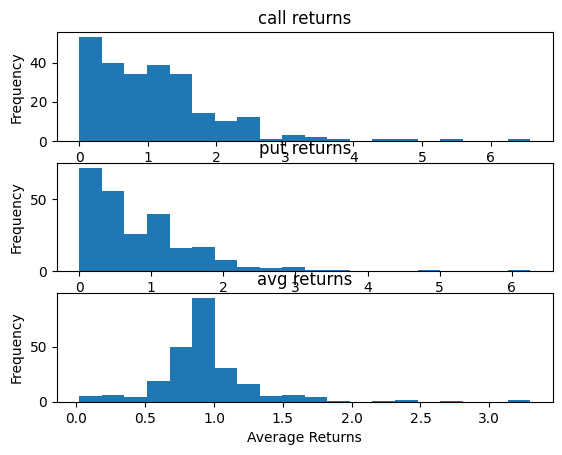

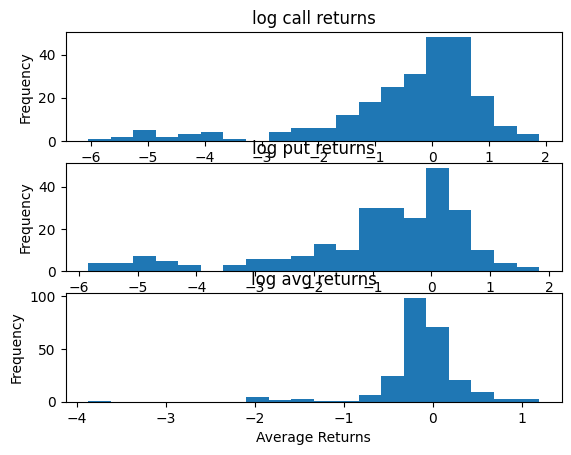

Quadrant 2: 0.4777327935222672 points
Quadrant 3: 0.340080971659919 points
Quadrant 4: 0.2793522267206478 points


In [351]:
plt.subplot(3,1,1)
plt.hist(outputDf["Call_Returns"], bins=20)
plt.xlabel("Call Returns")
plt.ylabel("Frequency")
plt.title("call returns")

plt.subplot(3,1,2)
plt.hist(outputDf["Put_Returns"], bins=20)
plt.xlabel("Put Returns")
plt.ylabel("Frequency")
plt.title("put returns")

plt.subplot(3,1,3)
plt.hist(outputDf["Average_Returns"], bins=20)
plt.xlabel("Average Returns")
plt.ylabel("Frequency")
plt.title("avg returns")

plt.show()


## log version
plt.subplot(3,1,1)
plt.hist(np.log(outputDf["Call_Returns"]), bins=20)
plt.xlabel("Call Returns")
plt.ylabel("Frequency")
plt.title("log call returns")

plt.subplot(3,1,2)
plt.hist(np.log(outputDf["Put_Returns"]), bins=20)
plt.xlabel("Put Returns")
plt.ylabel("Frequency")
plt.title("log put returns")

plt.subplot(3,1,3)
plt.hist(np.log(outputDf["Average_Returns"]), bins=20)
plt.xlabel("Average Returns")
plt.ylabel("Frequency")
plt.title("log avg returns")

plt.show()

n = len(outputDf)
# callret = np.sum(outputDf["Call_Returns"] > 1)/n  # x > 0, y < 0
callretlog = np.sum(np.log(outputDf["Call_Returns"])>0)/n  
putretlog = np.sum(np.log(outputDf["Put_Returns"])>0)/n 
avgretlog = np.sum(np.log(outputDf["Average_Returns"])>0)/n  

# Print counts
# print(f"Quadrant 1: {callret} points")
print(f"Quadrant 2: {callretlog} points")
print(f"Quadrant 3: {putretlog} points")
print(f"Quadrant 4: {avgretlog} points")

#### DTE dist

Text(0.5, 1.0, 'DTE (end)')

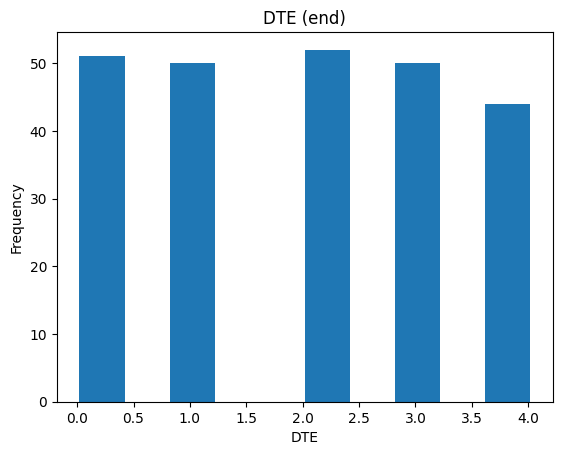

In [352]:
plt.hist(outputDf["DTE_end"])
plt.xlabel("DTE")
plt.ylabel("Frequency")
plt.title("DTE (end)")

### ITMness plot

Verdict: it tried to be ITM by -1 dollar, but it had to go up to 3 dollars ITM to find a fitting option


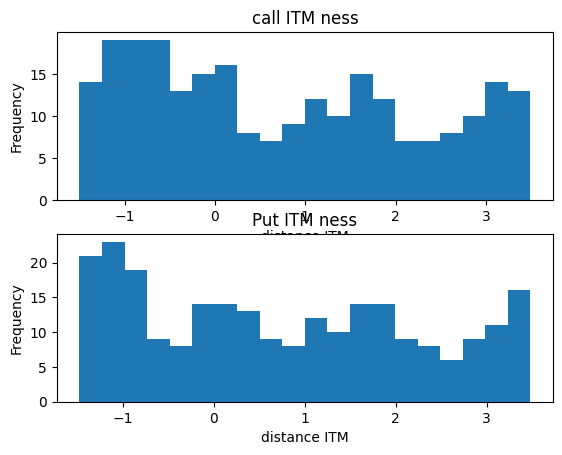

In [353]:
plt.subplot(2,1,1)
plt.hist(outputDf["Call_ITM"], bins=20)
plt.xlabel("distance ITM")
plt.ylabel("Frequency")
plt.title("call ITM ness")

plt.subplot(2,1,2)
plt.hist(outputDf["Put_ITM"], bins=20)
plt.xlabel("distance ITM")
plt.ylabel("Frequency")
plt.title("Put ITM ness")
print("Verdict: it tried to be ITM by -1 dollar, but it had to go up to 3 dollars ITM to find a fitting option")

### movement correlations analyses

dunderlying > 0: 0.5748987854251012 
dcall > 0: 0.4777327935222672 
dput > 0: 0.340080971659919 
dsum call+put > 0: 0.3319838056680162 


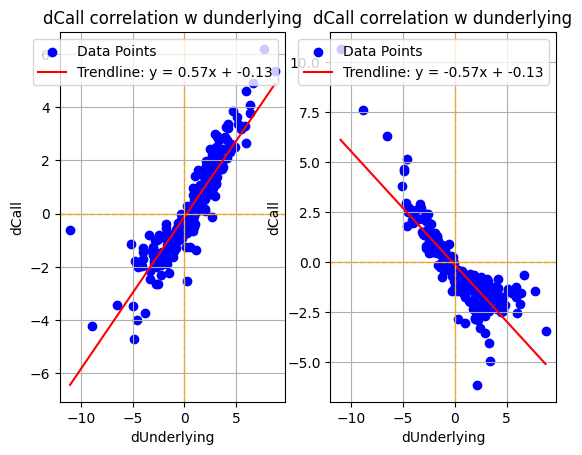

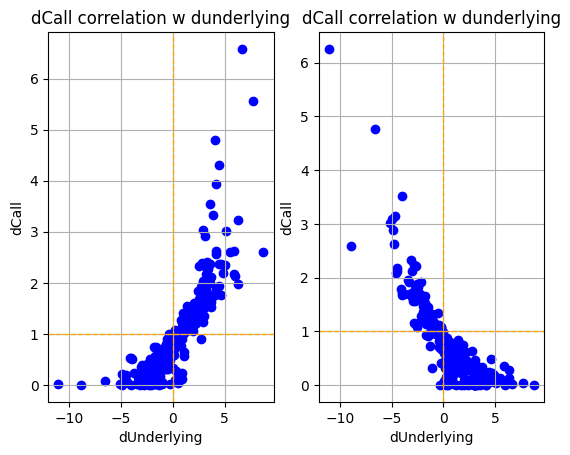

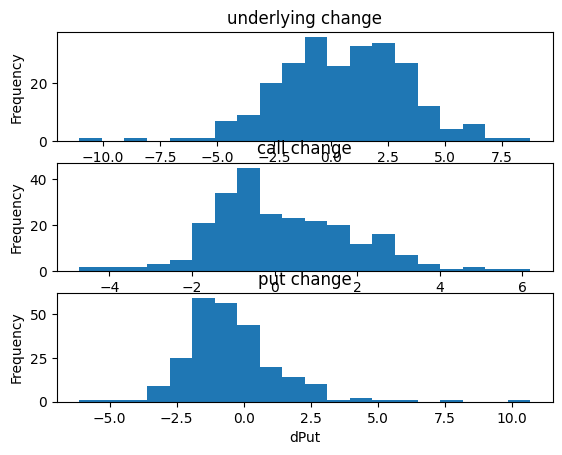

In [372]:
x = outputDf["dUnderlying"]
y1 = outputDf["dCall"]
y2 = outputDf["dPut"]

# plt.subplot(1,2,1)
# plt.plot(x, y1, ".", x, -y2, ".")
# plt.plot("")

plt.subplot(1,2,1)
coefficients = np.polyfit(x, y1, 1)  # 1 indicates a linear fit (degree 1)
trendline = np.poly1d(coefficients)  # Generate the trendline equation

# Extract the equation components
slope = coefficients[0]
intercept = coefficients[1]

# Create points for the trendline
x_trend = np.linspace(x.min(), x.max(), 100)  # Generate x values for the line
y1_trend = trendline(x_trend)                 # Calculate corresponding y values

# Plot the scatter plot and trendline
plt.scatter(x, y1, color='blue', label='Data Points')
plt.plot(x_trend, y1_trend, color='red', label=f'Trendline: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('dUnderlying')
plt.ylabel('dCall')
plt.title('dCall correlation w dunderlying')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
## for put
plt.subplot(1,2,2)
coefficients = np.polyfit(x, y2, 1)  # 1 indicates a linear fit (degree 1)
trendline = np.poly1d(coefficients)  # Generate the trendline equation

# Extract the equation components
slope = coefficients[0]
intercept = coefficients[1]

# Create points for the trendline
x_trend = np.linspace(x.min(), x.max(), 100)  # Generate x values for the line
y2_trend = trendline(x_trend)                 # Calculate corresponding y values

# Plot the scatter plot and trendline
plt.scatter(x, y2, color='blue', label='Data Points')
plt.plot(x_trend, y2_trend, color='red', label=f'Trendline: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('dUnderlying')
plt.ylabel('dCall')
plt.title('dCall correlation w dunderlying')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
####~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ dpercent
x = outputDf["dUnderlying"]
y3 = outputDf["Call_Returns"]
y4 = outputDf["Put_Returns"]

# plt.subplot(1,2,1)
# plt.plot(x, y3, ".", x, -y4, ".")
# plt.plot("")

plt.figure()
plt.subplot(1,2,1)
coefficients = np.polyfit(x, y3, 1)  # 1 indicates a linear fit (degree 1)
trendline = np.poly1d(coefficients)  # Generate the trendline equation

# Extract the equation components
slope = coefficients[0]
intercept = coefficients[1]

# Create points for the trendline
x_trend = np.linspace(x.min(), x.max(), 100)  # Generate x values for the line
y3_trend = trendline(x_trend)                 # Calculate corresponding y values

# Plot the scatter plot and trendline
plt.scatter(x, y3, color='blue', label='Data Points')
# plt.plot(x_trend, y3_trend, color='red', label=f'Trendline: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('dUnderlying')
plt.ylabel('dCall')
plt.title('dCall correlation w dunderlying')
# plt.legend()
plt.grid(True)
plt.axhline(y=1, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
## for put
plt.subplot(1,2,2)
coefficients = np.polyfit(x, y4, 1)  # 1 indicates a linear fit (degree 1)
trendline = np.poly1d(coefficients)  # Generate the trendline equation

# Extract the equation components
slope = coefficients[0]
intercept = coefficients[1]

# Create points for the trendline
x_trend = np.linspace(x.min(), x.max(), 100)  # Generate x values for the line
y4_trend = trendline(x_trend)                 # Calculate corresponding y values

# Plot the scatter plot and trendline
plt.scatter(x, y4, color='blue', label='Data Points')
# plt.plot(x_trend, y4_trend, color='red', label=f'Trendline: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('dUnderlying')
plt.ylabel('dCall')
plt.title('dCall correlation w dunderlying')
# plt.legend()
plt.grid(True)
plt.axhline(y=1, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)
#####~~~~~~~~~~~~~~~~~~~~~~~~~~~~histogram
plt.figure()
plt.subplot(3,1,1)
plt.hist(x, bins=20)
plt.xlabel("dUnderlying")
plt.ylabel("Frequency")
plt.title("underlying change")

plt.subplot(3,1,2)
plt.hist(y1, bins=20)
plt.xlabel("dCall")
plt.ylabel("Frequency")
plt.title("call change")

plt.subplot(3,1,3)
plt.hist(y2, bins=20)
plt.xlabel("dPut")
plt.ylabel("Frequency")
plt.title("put change")

n = len(outputDf)
dunderpos = np.sum(x>0)/n
dcallpos = np.sum(y1>0) /n
dputpos = np.sum(y2>0)  /n
dsumpos = np.sum((y1+y2)>0)/n
# Print counts
print(f"dunderlying > 0: {dunderpos} ")
print(f"dcall > 0: {dcallpos} ")
print(f"dput > 0: {dputpos} ")
print(f"dsum call+put > 0: {dsumpos} ")


<!-- ![call PnL diagram](callPL.png)  -->
<img src="callPL.png" alt="call PnL diagram" width="400">
<img src="putPL.png" alt="put PnL diagram" width="400">


### consecutive price movement analysis

Quadrant 1: 102 points
Quadrant 2: 40 points
Quadrant 3: 64 points
Quadrant 4: 40 points


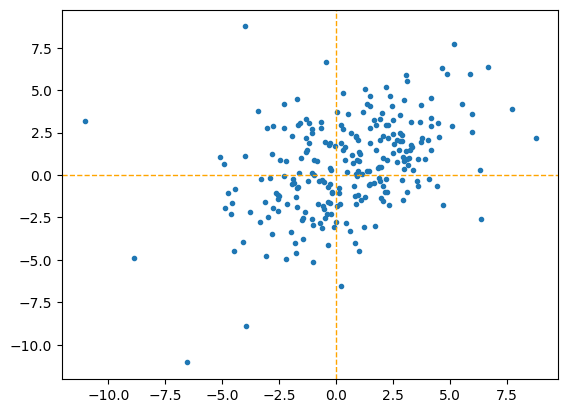

In [355]:
# x = underlying
x2 = x[1:].reset_index(drop=True)  # From the second element onward
x = x[:-1].reset_index(drop=True)  # Up to (but not including) the last element

plt.plot(x,x2,".")
plt.axhline(y=0, color='orange', linestyle='--', linewidth=1)
plt.axvline(x=0, color='orange', linestyle='--', linewidth=1)

# Count points in each quadrant
quadrant_1 = np.sum((x > 0) & (x2 > 0))  # x > 0, y > 0
quadrant_2 = np.sum((x < 0) & (x2 > 0))  # x < 0, y > 0
quadrant_3 = np.sum((x < 0) & (x2 < 0))  # x < 0, y < 0
quadrant_4 = np.sum((x > 0) & (x2 < 0))  # x > 0, y < 0

# Print counts
print(f"Quadrant 1: {quadrant_1} points")
print(f"Quadrant 2: {quadrant_2} points")
print(f"Quadrant 3: {quadrant_3} points")
print(f"Quadrant 4: {quadrant_4} points")


from the quadrants, it's pretty clear that price tends to do the same thing it did before. and kind of proportionately.  that kinda sucks.   
next, make a plot where you only keep the x1s that are above highest quartile in abs value of move. see if tihey have the same action

### Imrprovements to make
- maybe have underlying price be exact, then split strikes to be more even. mayb efor AAPL, do less than dollar strike prices
- intake the whole year a little better


### leverage space trading model
- get an avg win payout, avg loss payout. plot total payout as a function of f
- find longest period without volatlity, see hwo far drawdown is. calc risk of ruin
- 

0      0.115207
1      0.218391
2      1.565217
3      1.946721
4      0.691489
         ...   
242    0.574561
243    0.200000
244    0.006289
245    0.326633
246    0.323810
Name: Call_Returns, Length: 247, dtype: float64

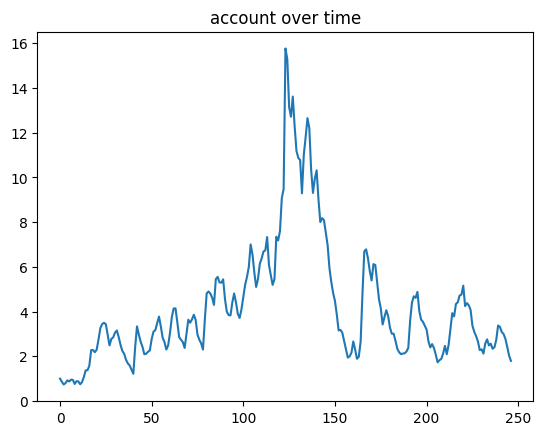

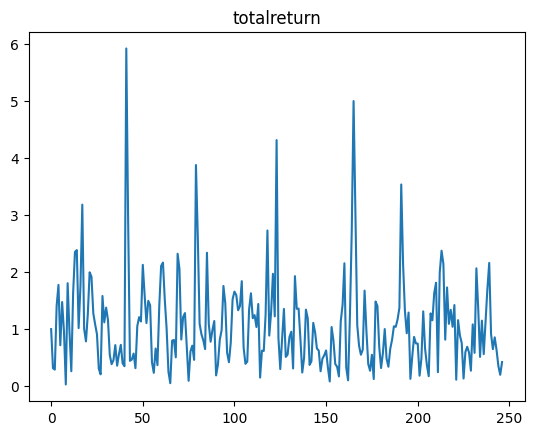

In [367]:
callbias = .9 # .5 means even split of call and puts. 1 means all calls
f = .2 # f is fraction of portfolio to put in 

callret = outputDf["Call_Returns"]
putret = outputDf["Put_Returns"]

y = [1] * len(callret)
totalret = [1] * len(callret)
for i in range(1,len(callret)):
    totalret[i] = callret[i-1] * callbias + putret[i-1]*(1 - callbias)
    y[i] = y[i-1] * ((1-f) + f*totalret[i]) 

plt.plot(range(0,len(callret)), y)
plt.title("account over time")

plt.figure()

plt.plot(range(0,len(callret)), totalret)
plt.title("totalreturn")
# w = 50 # win count
# l = 40 # loss count
# f = np.linspace(0,.5, 30)
# y = [0] * len(f)
# for i in range(0, len(f)):
#     y[i] = (1-f[i])**l * (1+f[i])**w

# plt.plot(f,y)
callret

Text(0.5, 1.0, 'return as a functino of callbias')

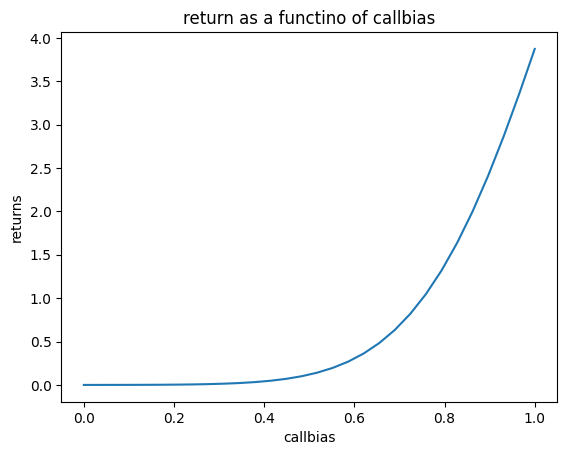

In [362]:
## Iterate over bias to see if there is a profitable one
f=.15#.25
callbias = np.linspace(0,1, 30)
y = [0] * len(callbias)
for i in range(0, len(callbias)):
    totalret = callret.shift(1) * callbias[i] + putret.shift(1) * (1 - callbias[i])
    y[i] = ((1 - f) + f * totalret).prod()

plt.plot(callbias,y)
plt.xlabel("callbias")
plt.ylabel("returns")
plt.title("return as a functino of callbias")

Text(0.5, 1.0, 'return as a functino of callbias')

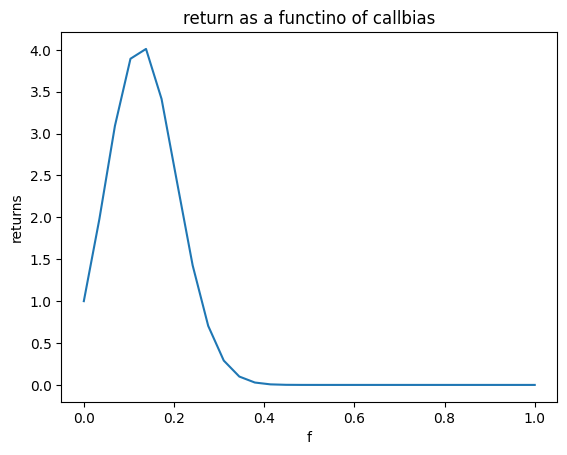

In [365]:
## Iterate over F this time to see if there is a profitable one
callbias=1#.25
f = np.linspace(0,1, 30)
y = [0] * len(f)
for i in range(0, len(f)):
    totalret = callret.shift(1) * callbias + putret.shift(1) * (1 - callbias)
    y[i] = ((1 - f[i]) + f[i] * totalret).prod()

plt.plot(f,y)
plt.xlabel("f")
plt.ylabel("returns")
plt.title("return as a functino of callbias")

### Next: try and prove or disprove a few hypotheses:
[Algo trading doc](https://docs.google.com/document/d/1YEOwA_mw6DXrr344ZhfSx-lL0AiTv3p9ow0gppLW0SY/edit?tab=t.0)
- just buying straddles everyday would be profitable
- buying straddles the day after big moves would be profitable
- buying straddles, more biased against the move of big move, the day after would be profitable
- the longer after a big move, the more you put down, would be profitbale
- correlate some indicators to volatility
- essentially you can guess on both voliatity and direction, and you jus tneed to be right on one to profit. or be right on both for big profit  
- look at how many days would be profitable, and your volatility indicator should prob be betting a good amt ~1.5x that many days?
- do a handcalc to find min portfolio value to make things work  
- lets do a handcalc for pseudo low f, higher leverage

The idea for making a bot to do all this is this: I want it to basically trade how i do, but take and hold positions, and adjust them everyday. however, I want it to "think" pretty much the same way that I do, but kind of implement a little bit more statistics into its "thought" process. Below I lay out the different classes and functions that make up the script. Let me do a pseudo code thought process here.

starting at day 0:
- using recent data, bot builds its beliefs of vol and dir at the current time.
- the portfolio obect is initiated
- class strategy looks at the portfolio and beliefs, and decides what it wants
    - it works with market class' methods to find the best fitting options to buy
  
[on to next iteration]  
Day 2:
- Bot builds new beliefs of vol and dir
- portfolio updates with status of current positions, cash avail, and more
- strategy uses beliefs, and current portofolio status to decide what it wants to do
    - normally, it'll just want to sell what it has and buy new ones
        - sometimes there will be deviations (like blackhjack) when certain things happen or certain criteria (could be parameter cutoffs) are met
    - other times, it'll choose to hold one of the positiosn and sell the other, or buy new with different DTEs n stuff
  
[onto next iteration, repeat of day 2. thats all you needa know]

### Coding overview
**class sentiment holds the beliefs for market**
- volatility belief
    - `vol` = f(previous day move size, significant events, card count, TA, time since last big move)
    - if vol belief has multiple dimensions, maybe that can be factored in for ideal position DTE
- direction belief
    - `dir` = f(previous day move size+direction, static bias, mean reversion, card count, TA)
- should this all be in one big coupled function per vol and dir? 
    - or should it be separate (a sep function to account for prev move and a sep func for sig events)?
  
**class option holds the properties for an option.**  
- it stores the current held positions and their values, and potential ones and their params.  
- `put1 = option() ; call1 = option()  `
  
**class portfolio**
- this hiolds the properties of the portfolio, it stores the current option positions  
  
**class market**
- this has methods to help make it easier to try and find the best matches for what the strategy wants to do
- it does not store the data itself but rather ways to use it

**class strategy**
- weaves together class sentiment, option, and portfolio to tell you given the current sentiment, market conditions(options values and potential options values), and portfolio holdings, how much to buy/sell, and keep and everything.
- "f" parameter goes here
  
**class backtest**
- holds the things needed to run a backtest.
- this includes a method called run that executes the backtest
- method called optimize that runs the the run method, and cycles thru params
- Afterward, data analysis and thinking can be done discretionally
  
**Main func-backtest**
- import downloaded data
- create arrays for all the data
- call the bt class thing
- post analysis

**main func-live implementation**
- use api to get data
- use api to get acct status
- do stuff
  

In the end, all the classes and functs should be in their own script, then the backtesting jupyter and live implentation .py are separate, importing the same file

code notes: when to use functions vs classes? use functions when your code is focused on ACTIONS. use classes when your code is focused on STATES  
usually functions are more simple to use. However, if you need to keep track of the state of something, a class can be more suitable. classes are often suitable for modeling real world concepts. and need to represent things. idk  
  
To avoid classes from getting too big, they should either be mainly data focused or behavior focused. ALSO. one important thing to consider abt classes is whether you actually need it or not. Classes are really msot useful if you need multiple instances of it. if you only need to make one, just made a module with functions. also encapsulation. classes should keep some stuff hidden which is nice.   
question: is belief based on belief from previous period? do some variables change based on the previous? or are they new every time? the answer to this question will answer whether sentiment should be a function or a class  

is sentiment and positions "1to1" ?

In [60]:
# THIS WHOLE THING HAS BEEN MOVED TO options_backtesting.py in core folder

In [ ]:
# ALL TESTING HAS BEEN MOVED TO test_backtester.ipynb in the tests/backtester folder

*example from chatGPT on formatting
# Coding Overview

## **Class Definitions and Purpose**

### **`class Hypothesis`**
This class encapsulates the market beliefs, including:

- **Volatility Belief (`vol`)**  
  Computed as a function of:
  - Previous day's move size
  - Significant events

- **Direction Belief (`dir`)**  
  Computed as a function of:
  - Previous day's move size and direction
  - Static bias
  - Mean reversion tendencies

**Design Question:**  
Should these be handled with:  
1. **One large, coupled function** for `vol` and `dir`?  
2. **Separate functions** for:
   - Previous move analysis  
   - Significant event handling  

---

### **`class Option`**
Represents the properties of an individual option, including:

- Current held positions and their values
- Potential option positions and their parameters

**Example Instances:**  
```python
put = Option()
call = Option()